In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras import metrics

#data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)
data = pd.read_csv('/Users/alket/Desktop/dati/new_data_Modena_backfill_forwfill.csv',index_col = 0)

# preparazione dati per due celle
agg_by_cell = data.groupby(by = ['cell_num'])

In [17]:
num_data = []
## prepare dataset
for i, k in agg_by_cell:
    cell_i = agg_by_cell.get_group(i)
    cell_i = cell_i.iloc[::4,:]
    # define input sequence
    series_i = cell_i['nr_people'].values
    series_i = series_i.reshape((len(series_i), 1))
    num_data.append(series_i)

In [18]:
print(num_data[:2][0])
print(len(num_data[:2]))

[[361.]
 [350.]
 [353.]
 ...
 [263.]
 [265.]
 [268.]]
2


In [19]:
final_data = hstack((num_data))
final_data.shape

(2952, 1353)

In [20]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequences)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the dataset
      if out_end_ix > len(sequences):
          break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 24, 8

# convert into input/output
X, y = split_sequences(final_data, n_steps_in, n_steps_out)

count = 0
for i in range(len(X)):
    count += 1
    print('inizia iterazione ', i)
    print(X[i], y[i])
    if count > 1: break
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))

inizia iterazione  0
[[361. 188. 336. ...  63.  57.  23.]
 [350. 182. 328. ...  65.  58.  24.]
 [353. 184. 329. ...  65.  58.  24.]
 ...
 [329. 175. 311. ...  62.  55.  22.]
 [334. 175. 308. ...  63.  56.  23.]
 [339. 176. 314. ...  62.  56.  22.]] [[350. 183. 322. ...  62.  56.  23.]
 [355. 184. 324. ...  62.  55.  23.]
 [354. 183. 325. ...  61.  55.  23.]
 ...
 [336. 175. 309. ...  60.  54.  22.]
 [324. 170. 301. ...  59.  54.  22.]
 [318. 167. 294. ...  59.  53.  22.]]
inizia iterazione  1
[[350. 182. 328. ...  65.  58.  24.]
 [353. 184. 329. ...  65.  58.  24.]
 [351. 182. 321. ...  65.  58.  24.]
 ...
 [334. 175. 308. ...  63.  56.  23.]
 [339. 176. 314. ...  62.  56.  22.]
 [350. 183. 322. ...  62.  56.  23.]] [[355. 184. 324. ...  62.  55.  23.]
 [354. 183. 325. ...  61.  55.  23.]
 [347. 179. 317. ...  61.  55.  22.]
 ...
 [324. 170. 301. ...  59.  54.  22.]
 [318. 167. 294. ...  59.  53.  22.]
 [311. 163. 289. ...  59.  54.  22.]]


In [21]:
#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
#train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1)
#print(len(train_X), len(train_y), len(test_X), len(test_y), len(val_X), len(val_y))
split_train_test = int(len(X)*0.75)
train_X, test_X = X[:split_train_test], X[split_train_test:]
train_y, test_y = y[:split_train_test], y[split_train_test:]
print(len(train_X), len(train_y), len(test_X), len(test_y))

2190 2190 731 731


In [22]:
for i in range(220):
    print(final_data[i][0])

361.0
350.0
353.0
351.0
339.0
333.0
329.0
331.0
324.0
315.0
319.0
315.0
313.0
305.0
302.0
297.0
299.0
302.0
312.0
305.0
322.0
329.0
334.0
339.0
350.0
355.0
354.0
347.0
336.0
336.0
324.0
318.0
311.0
306.0
313.0
298.0
296.0
294.0
303.0
301.0
302.0
308.0
316.0
322.0
326.0
334.0
340.0
347.0
351.0
356.0
350.0
350.0
348.0
346.0
353.0
354.0
416.0
498.0
534.0
532.0
541.0
522.0
514.0
541.0
530.0
540.0
484.0
446.0
404.0
385.0
391.0
393.0
391.0
384.0
381.0
377.0
381.0
378.0
370.0
371.0
389.0
438.0
553.0
553.0
553.0
569.0
551.0
554.0
560.0
556.0
505.0
461.0
404.0
391.0
385.0
376.0
378.0
374.0
374.0
371.0
373.0
371.0
365.0
371.0
426.0
508.0
540.0
555.0
551.0
537.0
518.0
527.0
535.0
556.0
541.0
481.0
427.0
419.0
406.0
396.0
392.0
390.0
383.0
378.0
378.0
375.0
363.0
366.0
420.0
494.0
548.0
541.0
547.0
543.0
512.0
531.0
526.0
526.0
486.0
457.0
400.0
399.0
409.0
412.0
415.0
415.0
396.0
382.0
369.0
364.0
362.0
363.0
365.0
373.0
368.0
378.0
371.0
362.0
339.0
338.0
337.0
344.0
340.0
348.0
343.0
353.0
366.

In [23]:
len(train_X)

2190

In [24]:
final_data.shape

(2952, 1353)

In [25]:
# define model
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=n_input)) 
model.add(Dense(250, activation='relu', input_dim=n_input)) 
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse',  metrics=[metrics.mae, 'accuracy'])

# fit model
model.fit(train_X, train_y, epochs=100, verbose=2)

Epoch 1/100
69/69 - 5s - loss: 103066.0391 - mean_absolute_error: 99.6899 - accuracy: 0.0498
Epoch 2/100
69/69 - 6s - loss: 72831.0312 - mean_absolute_error: 67.5627 - accuracy: 0.0863
Epoch 3/100
69/69 - 6s - loss: 43304.3242 - mean_absolute_error: 53.7062 - accuracy: 0.0982
Epoch 4/100
69/69 - 6s - loss: 34361.3867 - mean_absolute_error: 57.3680 - accuracy: 0.0826
Epoch 5/100
69/69 - 6s - loss: 23108.4355 - mean_absolute_error: 43.2388 - accuracy: 0.0968
Epoch 6/100
69/69 - 7s - loss: 42575.7344 - mean_absolute_error: 54.9905 - accuracy: 0.0804
Epoch 7/100
69/69 - 7s - loss: 19324.9609 - mean_absolute_error: 41.1219 - accuracy: 0.0913
Epoch 8/100
69/69 - 6s - loss: 20326.4961 - mean_absolute_error: 39.4112 - accuracy: 0.0890
Epoch 9/100
69/69 - 7s - loss: 20980.2695 - mean_absolute_error: 45.3429 - accuracy: 0.1251
Epoch 10/100
69/69 - 7s - loss: 27394.5762 - mean_absolute_error: 51.8666 - accuracy: 0.1027
Epoch 11/100
69/69 - 6s - loss: 15485.8887 - mean_absolute_error: 39.1250 - ac

Epoch 90/100
69/69 - 6s - loss: 4803.6499 - mean_absolute_error: 25.1806 - accuracy: 0.1534
Epoch 91/100
69/69 - 7s - loss: 4022.0393 - mean_absolute_error: 23.5050 - accuracy: 0.1689
Epoch 92/100
69/69 - 6s - loss: 3576.8716 - mean_absolute_error: 23.3537 - accuracy: 0.1721
Epoch 93/100
69/69 - 6s - loss: 4123.8979 - mean_absolute_error: 25.2125 - accuracy: 0.1817
Epoch 94/100
69/69 - 6s - loss: 4790.1079 - mean_absolute_error: 25.5141 - accuracy: 0.1607
Epoch 95/100
69/69 - 7s - loss: 8610.5889 - mean_absolute_error: 32.1642 - accuracy: 0.1776
Epoch 96/100
69/69 - 6s - loss: 6557.9971 - mean_absolute_error: 28.9946 - accuracy: 0.1785
Epoch 97/100
69/69 - 6s - loss: 9315.3164 - mean_absolute_error: 34.0518 - accuracy: 0.1699
Epoch 98/100
69/69 - 6s - loss: 4191.9346 - mean_absolute_error: 24.9677 - accuracy: 0.1662
Epoch 99/100
69/69 - 6s - loss: 5760.4268 - mean_absolute_error: 28.9470 - accuracy: 0.1626
Epoch 100/100
69/69 - 6s - loss: 7934.4629 - mean_absolute_error: 29.8635 - accu

In [26]:
predicted = np.array([])
for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_input))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0])

print(len(test_y))
var4diff2 = len(test_y)
print('shape ',test_y.shape )
exp_y = test_y.reshape((test_y.shape[0] * test_y.shape[1]))    
expected = exp_y    
print(len(expected))
print(len(predicted)) 

731
shape  (731, 10824)
7912344
7912344


Mean Absolute Error =  22.276558013427927


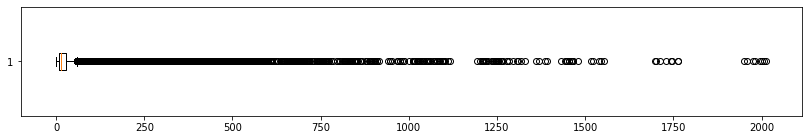

In [27]:
difference = abs(predicted - expected)
print('Mean Absolute Error = ', np.mean(difference))
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert = False)
plt.show()

In [28]:
shape_i = final_data.shape[1] * n_steps_out 
print(shape_i)


10824


In [29]:
difference2 = difference.reshape( var4diff2, shape_i)
print(difference2.shape)

(731, 10824)


In [30]:
MAPE = np.mean(abs(100 * (difference/expected)))
MAPE

15.307578174458381